In [1]:
import numpy as np
import cv2
from keras import backend as K
from keras.layers import Input, Dense, Flatten, Dropout, Concatenate
from keras.models import Model
import keras
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img,img_to_array
from keras.optimizers import Adam,SGD
from numpy import genfromtxt
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt
from keras import regularizers
import sys
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


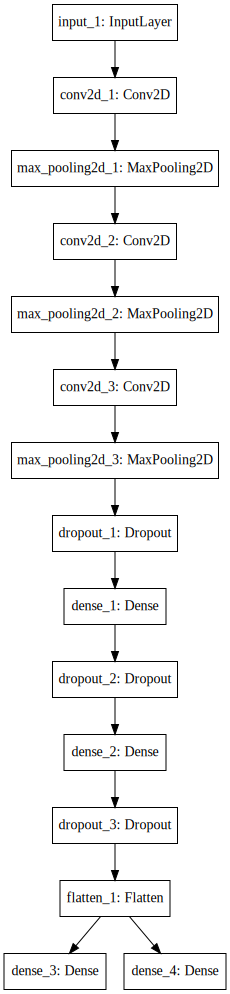

In [20]:
K.clear_session()
def create_model():
    input_im = Input(shape=(256,256,3))

    x = Conv2D(96, kernel_size=7, activation='relu')(input_im)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, kernel_size=5, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
   

    x = Conv2D(384, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
  
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
   
    x = Flatten()(x)
        
    gen = Dense(2, activation='softmax')(x)    
    age = Dense(8, activation='softmax')(x)

    model = Model(inputs=input_im, outputs=[gen,age]) 

    return model   
model=create_model()

model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
# usage : custom_gen(range(0,3000+1))

def custom_gen(_anns,use_range,batch_size):
    while True:
        image_data = []
        label_data_gender = []
        label_data_age = []
        start_indx = np.random.randint(low=use_range[0],high=use_range[-batch_size])
        
        # Read anns
        batch_row = _anns[start_indx:start_indx+batch_size]       
                    
        
        # Read images
        for row in batch_row:
            im = load_img('images/'+row[0]+'/'+row[2]+'.'+row[1],target_size=(256, 256,3))  #PIL Image          
            im = img_to_array(im) # Numpy
            im = im/255.
            image_data.append(im)               
            
            label_data_gender.append(np.fromstring(row[5], sep=' ')) # target gender
            label_data_age.append(np.fromstring(row[6], sep=' ')) # target gender
            
   
        image_data = np.array(image_data)
 
        
        yield( image_data, [label_data_gender,label_data_age] )       
        

In [13]:
# Read CSV annotations
train_anns = genfromtxt('anns/'+'train_anns.csv', delimiter=',',dtype=str)
val_anns = genfromtxt('anns/'+'val_anns.csv', delimiter=',',dtype=str)
np.random.shuffle(train_anns)
np.random.shuffle(val_anns)

train_range = range(0,100+1) # all = 10000
val_range = range(0,200+1) # all = 1332

print('train_range : ',train_range[0],'-',train_range[-1],\
      '\nval_range',val_range[0],'-',val_range[-1])
batch_size = 4

train_range :  0 - 100 
val_range 0 - 200


# TRAIN

In [17]:
early_stopping = EarlyStopping(monitor='val_dense_3_acc', min_delta=0.05, patience=0, verbose=1)
history = model.fit_generator(
        custom_gen(train_anns,train_range,batch_size), 
        steps_per_epoch=max(1, len(train_range)//batch_size),
        epochs=1,        
        validation_data=custom_gen(val_anns,val_range,batch_size),
        validation_steps=max(1, len(val_range)//batch_size),
        callbacks=[early_stopping])

Epoch 1/1
25/25 [==============================] - 58s 2s/step - loss: 2.8154 - dense_3_loss: 0.7040 - dense_4_loss: 2.1115 - dense_3_acc: 0.4700 - dense_4_acc: 0.2600 - val_loss: 2.7490 - val_dense_3_loss: 0.6950 - val_dense_4_loss: 2.0539 - val_dense_3_acc: 0.4800 - val_dense_4_acc: 0.2600


# TEST

In [19]:
gender_dict = ['m','f']
age_dict = ['(0-2)','(4-6)','(8-12)','(15-20)','(25-32)','(38-43)','(48-53)','(60-100)']

true_gen = 0
true_age = 0 
for i in range(0,100):
    sys.stdout.write("\r" + 'test images : '+str(i))
    sys.stdout.flush()
    #rand_indx = np.random.randint(low=0,high=1333)
    #rowp = val_anns[rand_indx]
    rowp = val_anns[i]
    im_ori = load_img('images/'+rowp[0]+'/'+rowp[2]+'.'+rowp[1],target_size=(256, 256,3))

    im = img_to_array(im_ori)
    im = im/255.
    im = np.expand_dims(im, axis=0)

    genderp,agep = model.predict(im)
    
    if rowp[4]==gender_dict[genderp.argmax()]:
        true_gen += 1
    if rowp[3]==age_dict[agep.argmax()]:
        true_age += 1
    
    
    #print(rowp[4]==gender_dict[genderp.argmax()],'\t',rowp[4],'\t\t|',gender_dict[genderp.argmax()],np.amax(genderp))
    #print(rowp[3]==age_dict[agep.argmax()],'\t',rowp[3],'\t|',age_dict[agep.argmax()],np.amax(agep))

#    display(im_ori)
   
print('\ncorrect-gender : ','{:d} prob-{:.2f}'.format(true_gen,true_gen/i),\
      '\ncorrect-age : ','{:d} prob-{:.2f}'.format(true_age,true_age/i)) 

test images : 99
correct-gender :  52 prob-0.53 
correct-age :  26 prob-0.26


In [ ]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
reset_weights(model)

In [ ]:
print (model.get_weights())

In [ ]:
model.save('my_model.h5')

In [ ]:
model = load_model('my_model.h5')